In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
"""
Things to check: Pooling/DropPath/cls_head_dropout > then best one add more blocks

68.33 % AdaptiveAvgPool2d((2,2)), cls_head_dropout = 0.5, 798,807, num_blocks = 10, No DropPath, v1 [Fail, overfitted]
69.72 % AdaptiveAvgPool2d((2,2)), cls_head_dropout = 0.5, 798,807, num_blocks = 10, DropPath 0.2, v1
69.65 % AdaptiveAvgPool2d((2,2)), cls_head_dropout = 0.5, 1,249,287, num_blocks = 16, DropPath 0.2, v1_16
AdaptiveAvgPool2d(1) $\rightarrow$ Flatten $\rightarrow$ Linear(32, 256)
"""

RUN_ID = "seresnet_new_v2"
model_save_name = "seresnet_new_v2"

In [4]:
class ChessDataset(Dataset):
    def __init__(self, root_dir: Path, split: str, sigma: float = 0.6):
        self.root_dir = Path(root_dir)
        self.split = split
        self.sigma = sigma
        self.num_classes = 7
        self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)
        self.X = np.load(self.root_dir / f"{self.split}_X.npy", mmap_mode='r')
        self.y = np.load(self.root_dir / f"{self.split}_y.npy", mmap_mode='r')
        self.scores = np.load(self.root_dir / f"{self.split}_scores.npy", mmap_mode='r')

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()
        
        x_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        hard_label = torch.tensor(self.y[idx], dtype=torch.long)

        # return self.X[idx], self.y[idx]
        return x_tensor, soft_target, hard_label

In [5]:
BATCH_SIZE = 512
num_workers = 0 
ROOT_DIR = Path("./dataset_planes_cp/")

train_dataset = ChessDataset(root_dir=ROOT_DIR, split="train")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)

val_dataset = ChessDataset(root_dir=ROOT_DIR, split="val")
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)

test_dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y, y_hard) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.0382101845741272


In [7]:
Xb, _, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype)

X batch shape: torch.Size([512, 19, 8, 8]) dtype: torch.float32
y batch shape: torch.Size([512]) dtype: torch.int64


In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, drop_prob=0.0):
        super().__init__()
        
        # bias = False because BatchNorm effectively cancels any bias term
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =  nn.BatchNorm2d(channels)
        self.bn2 =  nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.se = SEBlock(channels, reduction=8)
        self.drop_path = DropPath(drop_prob) if drop_prob > 0. else nn.Identity()

    # x is shape [19,8,8]
    def forward(self, x):
        identity = x 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        x = self.drop_path(x)
        x += identity
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        return x

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Squeeze: Global Average Pooling (turns Cx8x8 tensor into Cx1x1 tensor (not flattened))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Excitation: A tiny fully connected network to learn channel weights
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction), # Compress
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels), # Expand
            nn.Sigmoid() # Output a (0.0 to 1.0) for importance
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Calculate importance scores
        y = self.avg_pool(x).view(batch, channels)
        y = self.mlp(y).view(batch, channels, 1, 1)
        
        # Scale the original input by these scores
        return x * y.expand_as(x)
    
class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)

        # Create a mask of 1s and 0s
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        # Apply mask and scale output to maintain expected value
        return x.div(keep_prob) * random_tensor
    
class SEResNet(nn.Module):
    def __init__(self, in_channels=19, channels=64, num_blocks=10, num_classes=7, drop_path_rate=0.2):
        super().__init__()
        # Initial convolution on board
        self.initialconv = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

        dpr = [x.item() for x in torch.linspace(start=0, end=drop_path_rate, steps=num_blocks)]

        # Main residual block
        blocks = []
        for i in range(num_blocks):
            blocks.append(ResidualBlock(channels, drop_prob=dpr[i]))
        self.res_tower = nn.Sequential(*blocks)

        # Reduces channels to 32 before flattening
        self.bottleneck_channels = 32
        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels, self.bottleneck_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU()
        )

        # Classifier
        # self.flatten_dim = self.bottleneck_channels * 8 * 8
        self.flatten_dim = self.bottleneck_channels * 1 * 1
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)      
        )

    def forward(self, x):
        x = self.initialconv(x)
        x = self.res_tower(x)
        x = self.bottleneck(x)
        x = self.classifier(x)
        return x

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y, y_hard) in enumerate(dataloader):
            X, y, y_hard = X.to(device), y.to(device), y_hard.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y_hard).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [12]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=3
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [13]:
from torchinfo import summary

model = SEResNet(in_channels=19, 
                 channels=64, 
                 num_blocks=10, 
                 num_classes=7).to(device)

summary(model, input_size=(BATCH_SIZE, 19, 8, 8))

Layer (type:depth-idx)                        Output Shape              Param #
SEResNet                                      [512, 7]                  --
├─Sequential: 1-1                             [512, 64, 8, 8]           --
│    └─Conv2d: 2-1                            [512, 64, 8, 8]           10,944
│    └─BatchNorm2d: 2-2                       [512, 64, 8, 8]           128
│    └─ReLU: 2-3                              [512, 64, 8, 8]           --
├─Sequential: 1-2                             [512, 64, 8, 8]           --
│    └─ResidualBlock: 2-4                     [512, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                       [512, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2                  [512, 64, 8, 8]           128
│    │    └─ReLU: 3-3                         [512, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                       [512, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5                  [512, 64, 8, 8]           128
│    

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS + 1,
                        device=device)

Starting Training: seresnet_new_v2


  1%|          | 1/100 [09:30<15:40:51, 570.22s/it]

Epoch: 0 | New Best Val Acc: 0.4729 (Saved)
Epoch: 0 | Train Loss: 1.3637 | Val Loss: 1.4427 | Val Acc: 0.4729


  2%|▏         | 2/100 [18:35<15:07:33, 555.65s/it]

Epoch: 1 | New Best Val Acc: 0.5951 (Saved)
Epoch: 1 | Train Loss: 1.2463 | Val Loss: 1.2187 | Val Acc: 0.5951


  3%|▎         | 3/100 [27:34<14:45:42, 547.86s/it]

Epoch: 2 | New Best Val Acc: 0.6147 (Saved)
Epoch: 2 | Train Loss: 1.1996 | Val Loss: 1.1864 | Val Acc: 0.6147


  4%|▍         | 4/100 [36:32<14:30:13, 543.89s/it]

Epoch: 3 | New Best Val Acc: 0.6241 (Saved)
Epoch: 3 | Train Loss: 1.1724 | Val Loss: 1.1754 | Val Acc: 0.6241


  5%|▌         | 5/100 [45:31<14:18:31, 542.23s/it]

Epoch: 4 | New Best Val Acc: 0.6311 (Saved)
Epoch: 4 | Train Loss: 1.1545 | Val Loss: 1.1640 | Val Acc: 0.6311


  6%|▌         | 6/100 [54:35<14:10:44, 543.02s/it]

Epoch: No improvement. Patience 1/101
Epoch: 5 | Train Loss: 1.1415 | Val Loss: 1.1842 | Val Acc: 0.6123


  7%|▋         | 7/100 [1:03:40<14:02:40, 543.67s/it]

Epoch: 6 | New Best Val Acc: 0.6458 (Saved)
Epoch: 6 | Train Loss: 1.1313 | Val Loss: 1.1421 | Val Acc: 0.6458


  8%|▊         | 8/100 [1:12:44<13:53:27, 543.56s/it]

Epoch: 7 | New Best Val Acc: 0.6524 (Saved)
Epoch: 7 | Train Loss: 1.1230 | Val Loss: 1.1364 | Val Acc: 0.6524


  9%|▉         | 9/100 [1:21:46<13:43:42, 543.10s/it]

Epoch: 8 | New Best Val Acc: 0.6579 (Saved)
Epoch: 8 | Train Loss: 1.1164 | Val Loss: 1.1215 | Val Acc: 0.6579


 10%|█         | 10/100 [1:30:44<13:32:23, 541.60s/it]

Epoch: No improvement. Patience 1/101
Epoch: 9 | Train Loss: 1.1108 | Val Loss: 1.1348 | Val Acc: 0.6521


 11%|█         | 11/100 [1:40:08<13:33:43, 548.58s/it]

Epoch: 10 | New Best Val Acc: 0.6688 (Saved)
Epoch: 10 | Train Loss: 1.1063 | Val Loss: 1.1106 | Val Acc: 0.6688


 12%|█▏        | 12/100 [1:49:28<13:29:21, 551.83s/it]

Epoch: No improvement. Patience 1/101
Epoch: 11 | Train Loss: 1.1020 | Val Loss: 1.1410 | Val Acc: 0.6483


 13%|█▎        | 13/100 [1:58:24<13:13:26, 547.20s/it]

Epoch: No improvement. Patience 2/101
Epoch: 12 | Train Loss: 1.0985 | Val Loss: 1.1269 | Val Acc: 0.6551


 14%|█▍        | 14/100 [2:07:25<13:01:25, 545.18s/it]

Epoch: No improvement. Patience 3/101
Epoch: 13 | Train Loss: 1.0950 | Val Loss: 1.1204 | Val Acc: 0.6596


 15%|█▌        | 15/100 [2:16:31<12:52:36, 545.37s/it]

Epoch: No improvement. Patience 4/101
Epoch: 14 | Train Loss: 1.0919 | Val Loss: 1.1196 | Val Acc: 0.6576


 16%|█▌        | 16/100 [2:25:50<12:49:25, 549.59s/it]

Epoch: No improvement. Patience 5/101
Epoch: 15 | Train Loss: 1.0895 | Val Loss: 1.1185 | Val Acc: 0.6609


 17%|█▋        | 17/100 [2:35:40<12:57:05, 561.76s/it]

Epoch: No improvement. Patience 6/101
Epoch: 16 | Train Loss: 1.0867 | Val Loss: 1.1744 | Val Acc: 0.6203


 18%|█▊        | 18/100 [2:44:42<12:39:44, 555.91s/it]

Epoch: 17 | New Best Val Acc: 0.6702 (Saved)
Epoch: 17 | Train Loss: 1.0845 | Val Loss: 1.1032 | Val Acc: 0.6702


 19%|█▉        | 19/100 [2:53:49<12:26:43, 553.13s/it]

Epoch: No improvement. Patience 1/101
Epoch: 18 | Train Loss: 1.0823 | Val Loss: 1.1179 | Val Acc: 0.6590


 20%|██        | 20/100 [3:02:55<12:14:32, 550.90s/it]

Epoch: 19 | New Best Val Acc: 0.6782 (Saved)
Epoch: 19 | Train Loss: 1.0803 | Val Loss: 1.1004 | Val Acc: 0.6782


 21%|██        | 21/100 [3:12:00<12:03:13, 549.28s/it]

Epoch: No improvement. Patience 1/101
Epoch: 20 | Train Loss: 1.0786 | Val Loss: 1.1413 | Val Acc: 0.6451


 22%|██▏       | 22/100 [3:20:57<11:49:17, 545.61s/it]

Epoch: No improvement. Patience 2/101
Epoch: 21 | Train Loss: 1.0768 | Val Loss: 1.1029 | Val Acc: 0.6736


 23%|██▎       | 23/100 [3:29:52<11:35:57, 542.30s/it]

Epoch: 22 | New Best Val Acc: 0.6788 (Saved)
Epoch: 22 | Train Loss: 1.0752 | Val Loss: 1.0991 | Val Acc: 0.6788


 24%|██▍       | 24/100 [3:39:13<11:34:01, 547.91s/it]

Epoch: No improvement. Patience 1/101
Epoch: 23 | Train Loss: 1.0732 | Val Loss: 1.1186 | Val Acc: 0.6662


 25%|██▌       | 25/100 [3:48:28<11:27:28, 549.98s/it]

Epoch: 24 | New Best Val Acc: 0.6827 (Saved)
Epoch: 24 | Train Loss: 1.0718 | Val Loss: 1.0898 | Val Acc: 0.6827


 26%|██▌       | 26/100 [3:58:02<11:27:21, 557.32s/it]

Epoch: No improvement. Patience 1/101
Epoch: 25 | Train Loss: 1.0702 | Val Loss: 1.0935 | Val Acc: 0.6810


 27%|██▋       | 27/100 [4:07:25<11:20:02, 558.94s/it]

Epoch: 26 | New Best Val Acc: 0.6883 (Saved)
Epoch: 26 | Train Loss: 1.0688 | Val Loss: 1.0874 | Val Acc: 0.6883


 28%|██▊       | 28/100 [4:16:37<11:08:08, 556.79s/it]

Epoch: No improvement. Patience 1/101
Epoch: 27 | Train Loss: 1.0673 | Val Loss: 1.0893 | Val Acc: 0.6844


 29%|██▉       | 29/100 [4:25:45<10:55:56, 554.31s/it]

Epoch: No improvement. Patience 2/101
Epoch: 28 | Train Loss: 1.0660 | Val Loss: 1.0904 | Val Acc: 0.6793


 30%|███       | 30/100 [4:34:55<10:45:07, 552.97s/it]

Epoch: No improvement. Patience 3/101
Epoch: 29 | Train Loss: 1.0647 | Val Loss: 1.0951 | Val Acc: 0.6793


 31%|███       | 31/100 [4:44:00<10:33:09, 550.57s/it]

Epoch: No improvement. Patience 4/101
Epoch: 30 | Train Loss: 1.0636 | Val Loss: 1.0983 | Val Acc: 0.6755


 32%|███▏      | 32/100 [4:53:00<10:20:26, 547.44s/it]

Epoch: No improvement. Patience 5/101
Epoch: 31 | Train Loss: 1.0619 | Val Loss: 1.0914 | Val Acc: 0.6817


 33%|███▎      | 33/100 [5:02:02<10:09:23, 545.73s/it]

Epoch: No improvement. Patience 6/101
Epoch: 32 | Train Loss: 1.0607 | Val Loss: 1.0942 | Val Acc: 0.6812


 34%|███▍      | 34/100 [5:11:07<10:00:03, 545.51s/it]

Epoch: No improvement. Patience 7/101
Epoch: 33 | Train Loss: 1.0598 | Val Loss: 1.0969 | Val Acc: 0.6788


 35%|███▌      | 35/100 [5:20:16<9:52:18, 546.75s/it] 

Epoch: No improvement. Patience 8/101
Epoch: 34 | Train Loss: 1.0584 | Val Loss: 1.0886 | Val Acc: 0.6843


 36%|███▌      | 36/100 [5:29:50<9:51:43, 554.74s/it]

Epoch: No improvement. Patience 9/101
Epoch: 35 | Train Loss: 1.0570 | Val Loss: 1.0902 | Val Acc: 0.6859


 37%|███▋      | 37/100 [5:39:07<9:43:07, 555.36s/it]

Epoch: No improvement. Patience 10/101
Epoch: 36 | Train Loss: 1.0560 | Val Loss: 1.1132 | Val Acc: 0.6605


 38%|███▊      | 38/100 [5:48:21<9:33:27, 554.96s/it]

Epoch: 37 | New Best Val Acc: 0.6904 (Saved)
Epoch: 37 | Train Loss: 1.0549 | Val Loss: 1.0829 | Val Acc: 0.6904


 39%|███▉      | 39/100 [5:57:14<9:17:35, 548.45s/it]

Epoch: No improvement. Patience 1/101
Epoch: 38 | Train Loss: 1.0537 | Val Loss: 1.0832 | Val Acc: 0.6884


 40%|████      | 40/100 [6:06:06<9:03:31, 543.53s/it]

Epoch: No improvement. Patience 2/101
Epoch: 39 | Train Loss: 1.0525 | Val Loss: 1.0898 | Val Acc: 0.6841


 41%|████      | 41/100 [6:14:58<8:51:12, 540.21s/it]

Epoch: No improvement. Patience 3/101
Epoch: 40 | Train Loss: 1.0511 | Val Loss: 1.0863 | Val Acc: 0.6890


 42%|████▏     | 42/100 [6:23:51<8:39:51, 537.78s/it]

Epoch: 41 | New Best Val Acc: 0.6918 (Saved)
Epoch: 41 | Train Loss: 1.0501 | Val Loss: 1.0816 | Val Acc: 0.6918


 43%|████▎     | 43/100 [6:32:44<8:29:44, 536.57s/it]

Epoch: No improvement. Patience 1/101
Epoch: 42 | Train Loss: 1.0488 | Val Loss: 1.0931 | Val Acc: 0.6836


 44%|████▍     | 44/100 [6:41:37<8:19:43, 535.42s/it]

Epoch: No improvement. Patience 2/101
Epoch: 43 | Train Loss: 1.0477 | Val Loss: 1.0827 | Val Acc: 0.6883


 45%|████▌     | 45/100 [6:50:31<8:10:22, 534.95s/it]

Epoch: No improvement. Patience 3/101
Epoch: 44 | Train Loss: 1.0466 | Val Loss: 1.0822 | Val Acc: 0.6893


 46%|████▌     | 46/100 [6:59:25<8:01:11, 534.65s/it]

Epoch: No improvement. Patience 4/101
Epoch: 45 | Train Loss: 1.0453 | Val Loss: 1.0927 | Val Acc: 0.6861


 47%|████▋     | 47/100 [7:08:22<7:52:54, 535.37s/it]

Epoch: No improvement. Patience 5/101
Epoch: 46 | Train Loss: 1.0442 | Val Loss: 1.0835 | Val Acc: 0.6903


 48%|████▊     | 48/100 [7:17:18<7:44:16, 535.70s/it]

Epoch: No improvement. Patience 6/101
Epoch: 47 | Train Loss: 1.0430 | Val Loss: 1.0814 | Val Acc: 0.6903


 49%|████▉     | 49/100 [7:26:18<7:36:18, 536.83s/it]

Epoch: No improvement. Patience 7/101
Epoch: 48 | Train Loss: 1.0415 | Val Loss: 1.0859 | Val Acc: 0.6882


 50%|█████     | 50/100 [7:35:16<7:27:40, 537.21s/it]

Epoch: No improvement. Patience 8/101
Epoch: 49 | Train Loss: 1.0405 | Val Loss: 1.0963 | Val Acc: 0.6829


 51%|█████     | 51/100 [7:44:14<7:18:58, 537.53s/it]

Epoch: No improvement. Patience 9/101
Epoch: 50 | Train Loss: 1.0392 | Val Loss: 1.0820 | Val Acc: 0.6911


 52%|█████▏    | 52/100 [7:53:11<7:09:47, 537.24s/it]

Epoch: 51 | New Best Val Acc: 0.6926 (Saved)
Epoch: 51 | Train Loss: 1.0380 | Val Loss: 1.0798 | Val Acc: 0.6926


 53%|█████▎    | 53/100 [8:02:09<7:01:10, 537.66s/it]

Epoch: 52 | New Best Val Acc: 0.6945 (Saved)
Epoch: 52 | Train Loss: 1.0367 | Val Loss: 1.0808 | Val Acc: 0.6945


 54%|█████▍    | 54/100 [8:11:09<6:52:40, 538.28s/it]

Epoch: No improvement. Patience 1/101
Epoch: 53 | Train Loss: 1.0354 | Val Loss: 1.0937 | Val Acc: 0.6837


 55%|█████▌    | 55/100 [8:20:08<6:43:48, 538.41s/it]

Epoch: No improvement. Patience 2/101
Epoch: 54 | Train Loss: 1.0339 | Val Loss: 1.0826 | Val Acc: 0.6940


 56%|█████▌    | 56/100 [8:29:07<6:35:07, 538.80s/it]

Epoch: No improvement. Patience 3/101
Epoch: 55 | Train Loss: 1.0326 | Val Loss: 1.0840 | Val Acc: 0.6922


 57%|█████▋    | 57/100 [8:38:09<6:26:37, 539.49s/it]

Epoch: No improvement. Patience 4/101
Epoch: 56 | Train Loss: 1.0313 | Val Loss: 1.0865 | Val Acc: 0.6897


 58%|█████▊    | 58/100 [8:47:08<6:17:41, 539.57s/it]

Epoch: No improvement. Patience 5/101
Epoch: 57 | Train Loss: 1.0299 | Val Loss: 1.0855 | Val Acc: 0.6927


 59%|█████▉    | 59/100 [8:56:07<6:08:36, 539.44s/it]

Epoch: 58 | New Best Val Acc: 0.6952 (Saved)
Epoch: 58 | Train Loss: 1.0285 | Val Loss: 1.0807 | Val Acc: 0.6952


 60%|██████    | 60/100 [9:05:06<5:59:28, 539.20s/it]

Epoch: 59 | New Best Val Acc: 0.6954 (Saved)
Epoch: 59 | Train Loss: 1.0271 | Val Loss: 1.0818 | Val Acc: 0.6954


 61%|██████    | 61/100 [9:14:06<5:50:31, 539.26s/it]

Epoch: No improvement. Patience 1/101
Epoch: 60 | Train Loss: 1.0259 | Val Loss: 1.0810 | Val Acc: 0.6952


 62%|██████▏   | 62/100 [9:23:04<5:41:21, 539.00s/it]

Epoch: 61 | New Best Val Acc: 0.6955 (Saved)
Epoch: 61 | Train Loss: 1.0243 | Val Loss: 1.0826 | Val Acc: 0.6955


 63%|██████▎   | 63/100 [9:32:04<5:32:37, 539.40s/it]

Epoch: No improvement. Patience 1/101
Epoch: 62 | Train Loss: 1.0229 | Val Loss: 1.0861 | Val Acc: 0.6920


 64%|██████▍   | 64/100 [9:41:04<5:23:44, 539.56s/it]

Epoch: 63 | New Best Val Acc: 0.6960 (Saved)
Epoch: 63 | Train Loss: 1.0215 | Val Loss: 1.0801 | Val Acc: 0.6960


 65%|██████▌   | 65/100 [9:50:06<5:15:03, 540.10s/it]

Epoch: No improvement. Patience 1/101
Epoch: 64 | Train Loss: 1.0200 | Val Loss: 1.0814 | Val Acc: 0.6955


 66%|██████▌   | 66/100 [9:59:05<5:05:59, 539.99s/it]

Epoch: No improvement. Patience 2/101
Epoch: 65 | Train Loss: 1.0185 | Val Loss: 1.0920 | Val Acc: 0.6897


 67%|██████▋   | 67/100 [10:08:06<4:57:03, 540.11s/it]

Epoch: No improvement. Patience 3/101
Epoch: 66 | Train Loss: 1.0169 | Val Loss: 1.0842 | Val Acc: 0.6957


 68%|██████▊   | 68/100 [10:17:05<4:47:59, 539.97s/it]

Epoch: No improvement. Patience 4/101
Epoch: 67 | Train Loss: 1.0155 | Val Loss: 1.0861 | Val Acc: 0.6937


 69%|██████▉   | 69/100 [10:26:05<4:38:59, 539.97s/it]

Epoch: No improvement. Patience 5/101
Epoch: 68 | Train Loss: 1.0140 | Val Loss: 1.0885 | Val Acc: 0.6933


 70%|███████   | 70/100 [10:35:05<4:29:54, 539.83s/it]

Epoch: No improvement. Patience 6/101
Epoch: 69 | Train Loss: 1.0122 | Val Loss: 1.0844 | Val Acc: 0.6960


 71%|███████   | 71/100 [10:44:04<4:20:52, 539.73s/it]

Epoch: No improvement. Patience 7/101
Epoch: 70 | Train Loss: 1.0108 | Val Loss: 1.0859 | Val Acc: 0.6942


 72%|███████▏  | 72/100 [10:53:04<4:11:54, 539.82s/it]

Epoch: 71 | New Best Val Acc: 0.6984 (Saved)
Epoch: 71 | Train Loss: 1.0093 | Val Loss: 1.0848 | Val Acc: 0.6984


 73%|███████▎  | 73/100 [11:02:04<4:02:55, 539.82s/it]

Epoch: No improvement. Patience 1/101
Epoch: 72 | Train Loss: 1.0077 | Val Loss: 1.0851 | Val Acc: 0.6969


 74%|███████▍  | 74/100 [11:11:03<3:53:51, 539.68s/it]

Epoch: No improvement. Patience 2/101
Epoch: 73 | Train Loss: 1.0061 | Val Loss: 1.0865 | Val Acc: 0.6974


 75%|███████▌  | 75/100 [11:20:05<3:45:06, 540.27s/it]

Epoch: No improvement. Patience 3/101
Epoch: 74 | Train Loss: 1.0044 | Val Loss: 1.0859 | Val Acc: 0.6975


 76%|███████▌  | 76/100 [11:29:08<3:36:22, 540.95s/it]

Epoch: No improvement. Patience 4/101
Epoch: 75 | Train Loss: 1.0030 | Val Loss: 1.0952 | Val Acc: 0.6896


 77%|███████▋  | 77/100 [11:38:07<3:27:12, 540.56s/it]

Epoch: No improvement. Patience 5/101
Epoch: 76 | Train Loss: 1.0014 | Val Loss: 1.0916 | Val Acc: 0.6962


 78%|███████▊  | 78/100 [11:47:08<3:18:13, 540.62s/it]

Epoch: No improvement. Patience 6/101
Epoch: 77 | Train Loss: 0.9998 | Val Loss: 1.0902 | Val Acc: 0.6961


 79%|███████▉  | 79/100 [11:56:09<3:09:16, 540.80s/it]

Epoch: No improvement. Patience 7/101
Epoch: 78 | Train Loss: 0.9983 | Val Loss: 1.0898 | Val Acc: 0.6984


 80%|████████  | 80/100 [12:05:10<3:00:13, 540.66s/it]

Epoch: No improvement. Patience 8/101
Epoch: 79 | Train Loss: 0.9969 | Val Loss: 1.0926 | Val Acc: 0.6980


 81%|████████  | 81/100 [12:14:11<2:51:14, 540.78s/it]

Epoch: No improvement. Patience 9/101
Epoch: 80 | Train Loss: 0.9955 | Val Loss: 1.0924 | Val Acc: 0.6981


 82%|████████▏ | 82/100 [12:23:10<2:42:07, 540.43s/it]

Epoch: 81 | New Best Val Acc: 0.6994 (Saved)
Epoch: 81 | Train Loss: 0.9941 | Val Loss: 1.0921 | Val Acc: 0.6994


 83%|████████▎ | 83/100 [12:32:12<2:33:15, 540.93s/it]

Epoch: No improvement. Patience 1/101
Epoch: 82 | Train Loss: 0.9927 | Val Loss: 1.0956 | Val Acc: 0.6970


 84%|████████▍ | 84/100 [12:41:12<2:24:10, 540.65s/it]

Epoch: No improvement. Patience 2/101
Epoch: 83 | Train Loss: 0.9910 | Val Loss: 1.0963 | Val Acc: 0.6981


 85%|████████▌ | 85/100 [12:50:13<2:15:11, 540.78s/it]

Epoch: No improvement. Patience 3/101
Epoch: 84 | Train Loss: 0.9898 | Val Loss: 1.0955 | Val Acc: 0.6989


 86%|████████▌ | 86/100 [12:59:14<2:06:11, 540.84s/it]

Epoch: No improvement. Patience 4/101
Epoch: 85 | Train Loss: 0.9886 | Val Loss: 1.0972 | Val Acc: 0.6983


 87%|████████▋ | 87/100 [13:08:16<1:57:12, 540.96s/it]

Epoch: No improvement. Patience 5/101
Epoch: 86 | Train Loss: 0.9876 | Val Loss: 1.0984 | Val Acc: 0.6976


 88%|████████▊ | 88/100 [13:17:17<1:48:12, 541.07s/it]

Epoch: No improvement. Patience 6/101
Epoch: 87 | Train Loss: 0.9865 | Val Loss: 1.0990 | Val Acc: 0.6979


 89%|████████▉ | 89/100 [13:26:19<1:39:14, 541.32s/it]

Epoch: No improvement. Patience 7/101
Epoch: 88 | Train Loss: 0.9852 | Val Loss: 1.1005 | Val Acc: 0.6982


 90%|█████████ | 90/100 [13:35:21<1:30:14, 541.49s/it]

Epoch: No improvement. Patience 8/101
Epoch: 89 | Train Loss: 0.9845 | Val Loss: 1.1010 | Val Acc: 0.6974


 91%|█████████ | 91/100 [13:44:23<1:21:14, 541.58s/it]

Epoch: No improvement. Patience 9/101
Epoch: 90 | Train Loss: 0.9833 | Val Loss: 1.0998 | Val Acc: 0.6989


 92%|█████████▏| 92/100 [13:53:24<1:12:12, 541.53s/it]

Epoch: No improvement. Patience 10/101
Epoch: 91 | Train Loss: 0.9828 | Val Loss: 1.1016 | Val Acc: 0.6978


 93%|█████████▎| 93/100 [14:02:24<1:03:08, 541.19s/it]

Epoch: No improvement. Patience 11/101
Epoch: 92 | Train Loss: 0.9820 | Val Loss: 1.1031 | Val Acc: 0.6977


 94%|█████████▍| 94/100 [14:11:25<54:05, 540.86s/it]  

Epoch: No improvement. Patience 12/101
Epoch: 93 | Train Loss: 0.9814 | Val Loss: 1.1038 | Val Acc: 0.6973


 95%|█████████▌| 95/100 [14:20:25<45:03, 540.62s/it]

Epoch: No improvement. Patience 13/101
Epoch: 94 | Train Loss: 0.9807 | Val Loss: 1.1025 | Val Acc: 0.6994


 96%|█████████▌| 96/100 [14:29:26<36:03, 540.90s/it]

Epoch: No improvement. Patience 14/101
Epoch: 95 | Train Loss: 0.9804 | Val Loss: 1.1039 | Val Acc: 0.6981


 97%|█████████▋| 97/100 [14:38:27<27:02, 540.96s/it]

Epoch: No improvement. Patience 15/101
Epoch: 96 | Train Loss: 0.9801 | Val Loss: 1.1044 | Val Acc: 0.6979


 98%|█████████▊| 98/100 [14:47:29<18:02, 541.14s/it]

Epoch: No improvement. Patience 16/101
Epoch: 97 | Train Loss: 0.9797 | Val Loss: 1.1045 | Val Acc: 0.6984


 99%|█████████▉| 99/100 [14:56:29<09:00, 540.95s/it]

Epoch: No improvement. Patience 17/101
Epoch: 98 | Train Loss: 0.9796 | Val Loss: 1.1054 | Val Acc: 0.6972


100%|██████████| 100/100 [15:05:30<00:00, 543.30s/it]

Epoch: No improvement. Patience 18/101
Epoch: 99 | Train Loss: 0.9796 | Val Loss: 1.1042 | Val Acc: 0.6983

Loaded best model weights with Val Acc: 0.6994


In [15]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [16]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

Model Prediction:  5
Stockfish Evaluation:  5


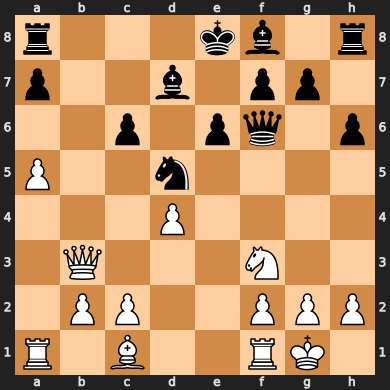

In [17]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_tensor(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [18]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y, y_hard in val_dataloader:
        X = X.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_hard.numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.82      0.82      0.82     85601
           1       0.65      0.64      0.65     85601
           2       0.64      0.64      0.64     85601
           3       0.63      0.67      0.65     85601
           4       0.67      0.66      0.66     85601
           5       0.66      0.63      0.65     85601
           6       0.81      0.83      0.82     85601

    accuracy                           0.70    599207
   macro avg       0.70      0.70      0.70    599207
weighted avg       0.70      0.70      0.70    599207



In [19]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [20]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, _, y_hard in dataloader:
            X = X.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_hard.numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [21]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
}

dataset_paths = {
    "train": str(ROOT_DIR / "train_X.npy"),
    "val":   str(ROOT_DIR / "val_X.npy"),
    "test":  str(ROOT_DIR / "test_X.npy")
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/seresnet_new_v2/seresnet_new_v2_config.json
[Logs] Saved training history to experiments/logs/seresnet_new_v2/seresnet_new_v2_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        69.75%
[Results] Off-by-1 Acc:    94.71%
[Results] MAE:             0.3848
[Results] Latency:         0.0824 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 8308 samples
   - Off by 4: 1955 samples
   - Off by 5: 1036 samples
   - Off by 6: 522 samples
[Results] Saved all metrics to experiments/results/seresnet_new_v2
------------------------------------------------------------


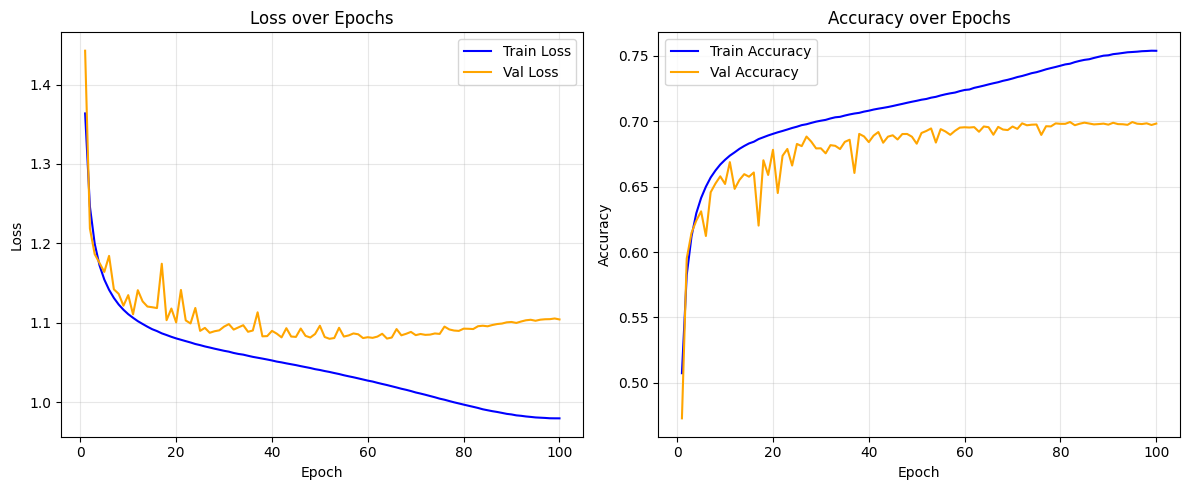

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

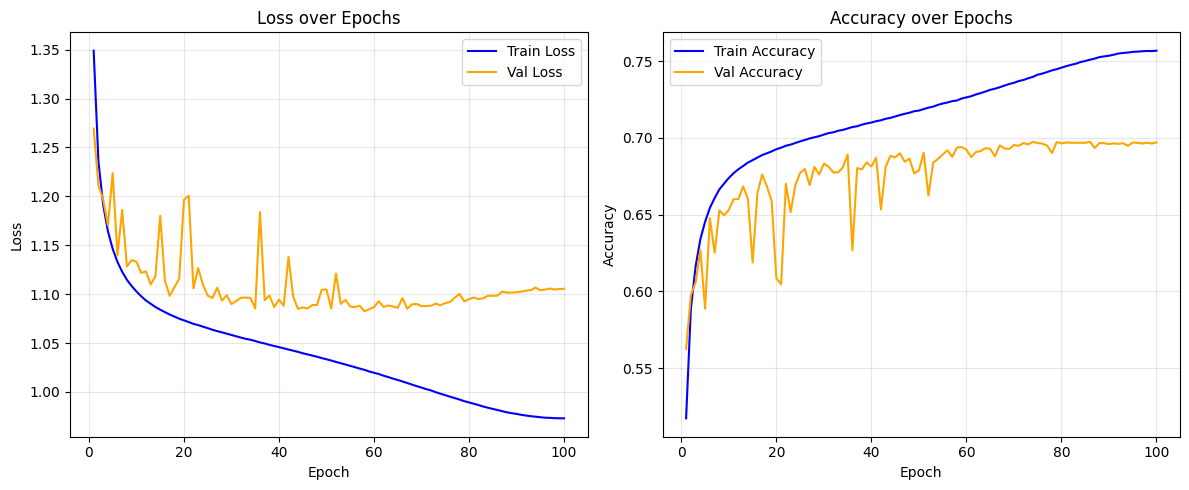

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

file_path = Path(f"./experiments/logs/probs_seresnet_droppath_c64_bn_v9/run_2026_01_15_probs_seresnet_droppath_c64_bn_v9_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()